Importing libraries

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import re
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes, svm
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

Extract data from file keeping only 4 columns

In [2]:
data = []

with open("Data/booksummaries/booksummaries.txt", encoding="utf8") as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in tqdm(reader):
        data.append(row)

book_id = []
book_name = []
summary = []
genre = []

for i in tqdm(data):
    book_id.append(i[0])
    book_name.append(i[2])
    genre.append(i[5])
    summary.append(i[6])

books = pd.DataFrame({'book_id': book_id, 'book_name': book_name,
                       'genre': genre, 'summary': summary})

books.head(2)

16559it [00:00, 23027.71it/s]
100%|██████████| 16559/16559 [00:00<00:00, 1086636.83it/s]


book_id           book_name  \
0     620         Animal Farm   
1     843  A Clockwork Orange   

                                               genre  \
0  {"/m/016lj8": "Roman \u00e0 clef", "/m/06nbt":...   
1  {"/m/06n90": "Science Fiction", "/m/0l67h": "N...   

                                             summary  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...

In [3]:
# json genres example
json.loads(books['genre'][1]).values()

print(f'Dataset size before cleaning: {len(books)}')

# drop data where genre is empty
books.drop(books[books['genre']==''].index, inplace=True)

# drop data where summary is empty
books.drop(books[books['summary']==''].index, inplace=True)


print(f'Dataset size after cleaning: {len(books)}')

Dataset size before cleaning: 16559
Dataset size after cleaning: 12841


In [4]:
s = books.summary.str.len().sort_values().index
books = books.reindex(s)[900:]
print(f'Dataset size after cleaning: {len(books)}')

Dataset size after cleaning: 11941


Decode JSON format in 'genre' column to 'new_genre' column\
Create a dictionary with all genres as keys and their number of occurrence as values

In [5]:
genres = []
for i in books['genre']:
    x = list(json.loads(i).values())
    genres.append(x)
books['genre_new'] = genres

genres_sum = sum(genres,[])
all_genres = {}

for g in set(genres_sum):
    all_genres[g] = genres_sum.count(g)

all_genres = dict(sorted(all_genres.items(), key=lambda x: x[1]))


Different genres count: 226
Top 40 popular genres:


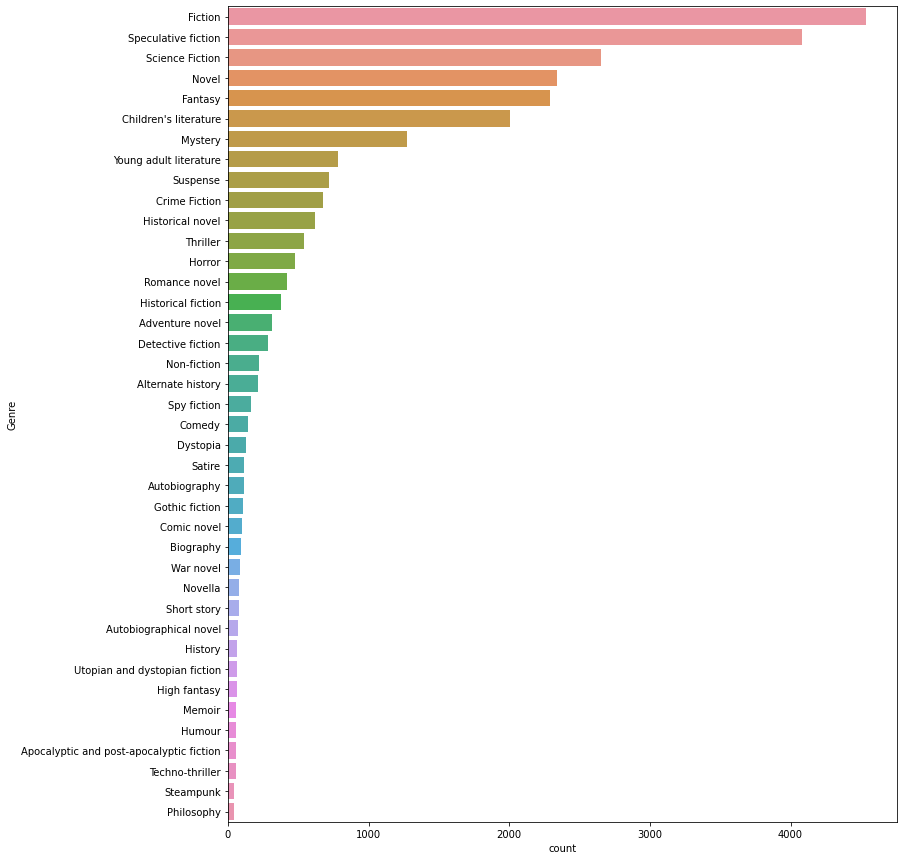

In [6]:
print(f'Different genres count: {len(all_genres)}')
print('Top 40 popular genres:')
vis = pd.DataFrame({'genre':list(all_genres.keys()), 'count':list(all_genres.values())}) 

# visualize genres and frequencies
dat = vis.nlargest(columns="count", n = 40) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=dat, x= "count", y = "genre") 
ax.set(ylabel = 'Genre') 
plt.show()

In [7]:
# remove_genres = list({key: value for key, value in all_genres.items() if value <= 700})
# remove_genres.append("Speculative fiction")
# all_genres = {key: value for key, value in all_genres.items() if value > 700}
# all_genres.pop('Speculative fiction')
genres_list = {"Fantasy", "Novel", "Crime Fiction", "Thriller", "Mystery"}
remove_genres = all_genres
for g in genres_list: 
    remove_genres.pop(g)
all_genres = genres_list

print(f'Remove genres number: {len(remove_genres)}')
print(f'All genres number: {len(all_genres)}')
print(all_genres)

Remove genres number: 221
All genres number: 5
{'Novel', 'Fantasy', 'Crime Fiction', 'Mystery', 'Thriller'}


In [8]:
# remove genres from dataset
for rem in remove_genres:
    i = 0
    for g in books['genre_new']:
        i += 1
        if rem in g: 
            g.remove(rem)

id_empty=[]
for id in books['book_id']:
    if books[books['book_id']==id]['genre_new'].tolist()[0] == []: 
        id_empty.append(id)

print(len(id_empty))

5895


In [9]:
# drop data where genre is empty
for id in id_empty:
    books.drop(books[books['book_id']==id].index, inplace=True)

genres = []
for i in books['genre_new']:
    x = list(i)[0]
    genres.append(x)
books['genre'] = genres

Preprocessing text functions:
- to lowercase
- remove everething except letters
- remove whitespaces 
- remove stop words
- text stemming (Porter)
<img src="https://user.oc-static.com/upload/2020/10/22/16033551309054_stemming%20example.png" alt="drawing" width="300"/>

In [10]:
def preprocess(text):
    text = re.sub("\'", "", str(text)) 
    text = re.sub("[^a-zA-Z]", " ", str(text)) 
    text = ' '.join(text.split()) 
    text = text.lower() 

    return text

books['clear_summary'] = books['summary'].apply(lambda x: preprocess(x))

In [11]:
# Removing stop words ("a", "an"...)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

books['clear_summary'] = books['clear_summary'].apply(lambda x: remove_stopwords(x))

In [12]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stemming(text):
    stemText = ""
    for word in text.split():
        stem = stemmer.stem(word)
        stemText += stem
        stemText += " "
    stemText = stemText.strip()
    return stemText

books['clear_summary'] = books['clear_summary'].apply(lambda x: stemming(x))

In [13]:
# After summary preprocessing
print(f'data size: {len(books)}')
books.groupby('genre').count()

data size: 6046


book_id  book_name  summary  genre_new  clear_summary
genre                                                               
Crime Fiction      606        606      606        606            606
Fantasy           2144       2144     2144       2144           2144
Mystery            750        750      750        750            750
Novel             2004       2004     2004       2004           2004
Thriller           542        542      542        542            542

Encode target labels with value between 0 and n_classes-1.

In [14]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(books['genre'])
encoder.inverse_transform([0,1,2,3,4])

array(['Crime Fiction', 'Fantasy', 'Mystery', 'Novel', 'Thriller'],
      dtype=object)

Convert text to numbers using TFIDF (term frequency–inverse document frequency) approach

+ **Term frequency** = (Number of Occurrences of a word)/(Total words in the document)
+ **IDF(word)** = Log((Total number of documents)/(Number of documents containing the word))

*max_features* - equal to 4000, which means we want to use the 4000 most frequently occurring words as features to train our classifier.\
*min_df* - ignore terms that have a document frequency strictly lower than the given number\
*max_df* - include only those words that appear in a maximum of 65% of all documents\
(Words that appear in almost every document are usually not suitable for classification because they do not provide any unique information about the document)

In [142]:
tfidfconverter = TfidfVectorizer(max_features=6000, min_df=10, max_df=0.65)
X = tfidfconverter.fit_transform(books['clear_summary'])

Chi-square feature selection 

In [143]:
# K features with highest chi-squared statistics are selected
chi2_features = SelectKBest(chi2, k = 1500)
print(X.shape)
X = chi2_features.fit_transform(X, y)
print(X.shape)

(6046, 6000)
(6046, 1500)


Splitting data into training and test sets (90%/10%)

In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

1. Naive Bayes Classifier Algorithm & model evaluation


In [147]:
# fitting the classification model
classifier_nb = naive_bayes.MultinomialNB()

# x10 cross validation
cv_results = cross_validate(classifier_nb, X_train, y_train, cv=10, return_estimator=True)
print(cv_results['test_score'])
index_best = np.argmax(cv_results['test_score'])
print(f'best model: {index_best}')
classifier_nb = cv_results['estimator'][index_best]

# predict genre on test dataset
y_pred = classifier_nb.predict(X_test)

# Model evaluation
#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(f'Accurancy {accuracy_score(y_test, y_pred)}')

print(y_test[:15])
print(y_pred[:15])

[0.73211009 0.72242647 0.69669118 0.71691176 0.70772059 0.70772059
 0.73161765 0.69669118 0.73345588 0.68566176]
best model: 8
              precision    recall  f1-score   support

           0       0.91      0.52      0.67        61
           1       0.82      0.84      0.83       216
           2       0.87      0.44      0.58        78
           3       0.58      0.92      0.71       192
           4       1.00      0.09      0.16        58

    accuracy                           0.71       605
   macro avg       0.84      0.56      0.59       605
weighted avg       0.78      0.71      0.68       605

Accurancy 0.7090909090909091
[1 3 2 0 3 3 0 2 1 1 3 3 1 3 3]
[1 3 1 0 3 3 1 2 1 1 3 3 1 3 3]


Testing hiper-parametr alpha of the MultinomialNB classifier

In [154]:
from sklearn.model_selection import GridSearchCV
c_nb = naive_bayes.MultinomialNB()

# Grid search with x10 cross validation
params = [{'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1]}]
gs = GridSearchCV(c_nb,
                param_grid=params,
                cv=10)
gs.fit(X_train, y_train)
print("Best alpha: ", gs.best_params_)
print("Best score: ", gs.best_score_)
gs_y = gs.predict(X_test)
print(f'Accurancy {accuracy_score(y_test, gs_y)}')

Best alpha:  {'alpha': 0.1}
Best score:  0.7516945493793848
Accurancy 0.7487603305785124


2. SVM algorithm using the RBF (Gaussian) kernel (Gamma = 1, default C = 10)

In [141]:
# fitting the classification model
classifier_svc = svm.SVC(C = 10, kernel='rbf',gamma=1)

# x10 cross validation
cv_results = cross_validate(classifier_svc, X_train, y_train, cv=10, return_estimator=True)
print(cv_results['test_score'])
index_best = np.argmax(cv_results['test_score'])
print(f'best model: {index_best}')
classifier_svc = cv_results['estimator'][index_best]

y_pred=classifier_svc.predict(X_test)

# Model evaluation
#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(f'Accurancy {accuracy_score(y_test, y_pred)}')

[0.72451791 0.68595041 0.73002755 0.70247934 0.74104683 0.74655647
 0.72727273 0.75414365 0.73480663 0.72375691]
best model: 7
              precision    recall  f1-score   support

           0       0.62      0.56      0.59       243
           1       0.82      0.83      0.82       869
           2       0.65      0.58      0.61       282
           3       0.70      0.79      0.74       802
           4       0.55      0.44      0.49       223

    accuracy                           0.72      2419
   macro avg       0.67      0.64      0.65      2419
weighted avg       0.72      0.72      0.72      2419

Accurancy 0.7209590739975197


SVM hyperparameters: Gamma = 0.1, C = 10

In [ ]:
# fitting the classification model
classifier_svc = svm.SVC(C = 10, kernel='rbf',gamma=0.1)

# x5 cross validation
cv_results = cross_validate(classifier_svc, X_train, y_train, cv=10, return_estimator=True)
print(cv_results['test_score'])
index_best = np.argmax(cv_results['test_score'])
print(f'best model: {index_best}')
classifier_svc = cv_results['estimator'][index_best]

y_pred=classifier_svc.predict(X_test)

# Model evaluation
#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(f'Accurancy {accuracy_score(y_test, y_pred)}')

[0.73211009 0.74264706 0.71875    0.73713235 0.73161765 0.73161765
 0.73345588 0.72977941 0.73897059 0.75      ]
best model: 9
              precision    recall  f1-score   support

           0       0.72      0.65      0.68        66
           1       0.84      0.90      0.87       228
           2       0.70      0.46      0.55        81
           3       0.71      0.78      0.74       187
           4       0.59      0.60      0.60        43

    accuracy                           0.75       605
   macro avg       0.71      0.68      0.69       605
weighted avg       0.75      0.75      0.75       605

Accurancy 0.7537190082644628


SVM hyperparameters: Gamma = 10, C = 10

In [ ]:
# fitting the classification model
classifier_svc = svm.SVC(C = 10, kernel='rbf',gamma=10)

# x5 cross validation
cv_results = cross_validate(classifier_svc, X_train, y_train, cv=10, return_estimator=True)
print(cv_results['test_score'])
index_best = np.argmax(cv_results['test_score'])
print(f'best: {index_best}')
classifier_svc = cv_results['estimator'][index_best]

y_pred=classifier_svc.predict(X_test)

# Model evaluation
#print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(f'Accurancy {accuracy_score(y_test, y_pred)}')

[0.3559633  0.35294118 0.35110294 0.35110294 0.35294118 0.35294118
 0.35477941 0.35477941 0.35477941 0.35477941]
best: 0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.38      1.00      0.55       228
           2       0.00      0.00      0.00        81
           3       1.00      0.01      0.01       187
           4       0.00      0.00      0.00        43

    accuracy                           0.38       605
   macro avg       0.28      0.20      0.11       605
weighted avg       0.45      0.38      0.21       605

Accurancy 0.3785123966942149


c:\Users\Asus\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Asus\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Asus\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera